In [ ]:
!pip install Ninja
!pip install wandb

In [6]:
from PIL import Image
import pandas as pd
import os, cv2, wandb
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing.git

In [ ]:
!git clone https://github.com/Healthcare-Robotics/bodies-at-rest.git

In [ ]:
wandb.init(project="Self-Correction-Human-Parsing-Binary-Images")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!mkdir Self-Correction-Human-Parsing-Segmented-Dataset
!mkdir Self-Correction-Human-Parsing-Dataset

In [ ]:
%cd Self-Correction-Human-Parsing

/content/Self-Correction-Human-Parsing


In [ ]:
!mkdir input
!mkdir output
!mkdir dataset
!mkdir rgb-test-imgs

In [ ]:
%cd /content/bodies-at-rest/PressurePose

/content/bodies-at-rest/PressurePose


In [ ]:
!chmod +x download_real.sh
!bash download_real.sh

In [ ]:
object = pd.read_pickle(r'/content/bodies-at-rest/data_BR/real/S103/prescribed.p')
print(len(object['RGB']))
print(object['RGB'][0].shape)

48
(880, 440, 3)


In [ ]:
path = "/content/bodies-at-rest/data_BR/real/"
folders = os.listdir(path)
w, h = 880, 440

for i, folder in enumerate(folders):
  object = pd.read_pickle(r'/content/bodies-at-rest/data_BR/real/'+ folder +'/prescribed.p')
  for j in range(0, len(object['RGB'])):
    rgb_img = np.zeros((h, w, 3), dtype=np.uint8)
    rgb_img = object['RGB'][j]
    rgb_img = Image.fromarray(rgb_img, 'RGB')
    rgb_img.save(f'/content/Self-Correction-Human-Parsing-Dataset/{i}{j}.jpg')

In [ ]:
!python '/content/Self-Correction-Human-Parsing/simple_extractor.py' --dataset 'pascal' --model-restore '/content/drive/MyDrive/models/exp-schp-201908270938-pascal-person-part.pth' --input-dir '/content/Self-Correction-Human-Parsing-Dataset' --output-dir '/content/Self-Correction-Human-Parsing-Segmented-Dataset'

Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 914/914 [03:58<00:00,  3.83it/s]


In [ ]:
path = "/content/Self-Correction-Human-Parsing-Segmented-Dataset/"
segmented_images = os.listdir(path)

len(segmented_images)

914

In [ ]:
%cd /content/Self-Correction-Human-Parsing/dataset/
!mkdir train_images
!mkdir train_segmentations
!mkdir val_images
!mkdir val_segmentations

/content/Self-Correction-Human-Parsing/dataset


In [ ]:
train_id = open('train_id.txt', 'w')
val_id = open('val_id.txt', 'w')

for i ,image in enumerate(segmented_images):
  img = cv2.imread(os.path.join(path, image))
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray[img_gray > 0] = 255
  img_gray[img_gray == 0] = 0
  image_name = image.split('.')[0]
  if i < 800:
    cv2.imwrite(f"train_images/{image_name}.jpg", img_gray)
    train_id.write(f"{image_name}")
    train_id.write('\n')
  else:
    cv2.imwrite(f"val_images/{image_name}.jpg", img_gray)
    val_id.write(f"{image_name}")
    val_id.write('\n')

train_id.close()
val_id.close()

In [ ]:
path = "/content/Self-Correction-Human-Parsing-Segmented-Dataset/"
segmented_images = os.listdir(path)

for i, image in enumerate(segmented_images):
  img_rgb = cv2.imread(os.path.join(path, image))
  img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

  img_gray[img_gray == 0] = 0
  img_gray[img_gray == 15] = 1
  img_gray[img_gray == 38] = 2
  img_gray[img_gray == 53] = 3
  img_gray[img_gray == 75] = 4
  img_gray[img_gray == 90] = 5
  img_gray[img_gray == 113] = 6

  if i < 800:
    cv2.imwrite(f"train_segmentations/{image}", img_gray)
  else:
    cv2.imwrite(f"val_segmentations/{image}", img_gray)

In [ ]:
%cd /content/Self-Correction-Human-Parsing/
!mkdir pretrain_model

/content/Self-Correction-Human-Parsing


In [ ]:
import gdown

url = "http://sceneparsing.csail.mit.edu/model/pretrained_resnet/resnet101-imagenet.pth"
out = "/content/Self-Correction-Human-Parsing/pretrain_model/resnet101-imagenet.pth"
gdown.download(url, out) 

Downloading...
From: http://sceneparsing.csail.mit.edu/model/pretrained_resnet/resnet101-imagenet.pth
To: /content/Self-Correction-Human-Parsing/pretrain_model/resnet101-imagenet.pth
100%|██████████| 179M/179M [00:05<00:00, 30.4MB/s]


'/content/Self-Correction-Human-Parsing/pretrain_model/resnet101-imagenet.pth'

In [ ]:
!python '/content/Self-Correction-Human-Parsing/train.py' --batch-size 2 --data-dir '/content/Self-Correction-Human-Parsing/dataset' --epochs 10 --num-classes 7

wandb: Currently logged in as: maryamboneh (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.11
wandb: Run data is saved locally in /content/Self-Correction-Human-Parsing/wandb/run-20220314_132250-359vxtel
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run strawberry-brulee-3
wandb: ⭐️ View project at https://wandb.ai/maryamboneh/Self-Correction-Human-Parsing-Binary-Images
wandb: 🚀 View run at https://wandb.ai/maryamboneh/Self-Correction-Human-Parsing-Binary-Images/runs/359vxtel
Namespace(arch='resnet101', batch_size=2, cycle_epochs=10, data_dir='/content/Self-Correction-Human-Parsing/dataset', epochs=10, eval_epochs=10, gpu='0,1,2', ignore_label=255, imagenet_pretrain='./pretrain_model/resnet101-imagenet.pth', input_size='473,473', lambda_c=0.1, lambda_e=1, lambda_s=1, learning_rate=0.007, log_dir='./log', model_restore='./log/checkpoint.pth.tar', momentum=0.9, num_classes=7, random_mirror=False, random_scale=False, schp_restore

## Inference

In [5]:
!python '/content/drive/MyDrive/Self-Correction-Human-Parsing/simple_extractor.py' --dataset 'pascal' --model-restore '/content/drive/MyDrive/Self-Correction-Human-Parsing/log/checkpoint_10.pth.tar' --input-dir '/content/drive/MyDrive/Self-Correction-Human-Parsing/input' --output-dir '/content/drive/MyDrive/Self-Correction-Human-Parsing/output'

Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 3/3 [00:02<00:00,  1.11it/s]


Text(0.5, 1.0, 'output_img')

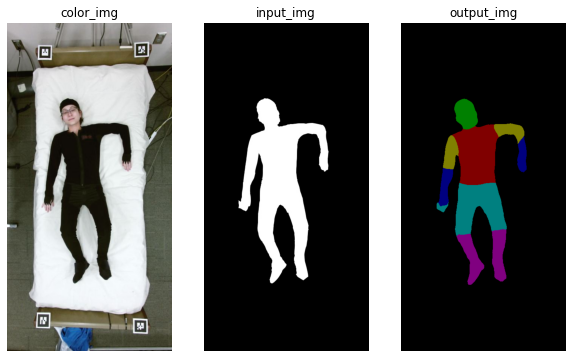

In [16]:
fig = plt.figure(figsize=(10, 8))

color_img = cv2.imread("/content/drive/MyDrive/Self-Correction-Human-Parsing/rgb-test-imgs/3.jpeg")
input_img = cv2.imread("/content/drive/MyDrive/Self-Correction-Human-Parsing/input/3.jpg")
output_img = cv2.imread("/content/drive/MyDrive/Self-Correction-Human-Parsing/output/3.png")

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(color_img)
plt.axis('off')
plt.title("color_img")

fig.add_subplot(rows, columns, 2)
plt.imshow(input_img)
plt.axis('off')
plt.title("input_img")

fig.add_subplot(rows, columns, 3)
plt.imshow(output_img)
plt.axis('off')
plt.title("output_img")